In [37]:
import numpy as np
import xarray as xr
import xrft
import gsw
import os.path as op
import dask.array.fft as fft
from dask.diagnostics import ProgressBar
from oceanmodes import instability_analysis_from_N2_profile as insta
from oceanmodes import neutral_modes_from_N2_profile as neu
from scipy.interpolate import PchipInterpolator as pchip
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
import matplotlib.ticker as tick
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [38]:
ddir = '/swot/SUM02/takaya/'
avisodir = '/swot/SUM03/avisoftp.cnes.fr/AVISO/pub/jason-2/gdr_d'

In [87]:
14*(30*24)

10080

In [39]:
ys, dy = (5,1)
dt = 4e1
ts = int((ys*360*86400)/dt)
te = int(ts + dy*360*86400/dt)
print(ts,te)

3888000 4665600


In [29]:
f0 = -1.1e-4
beta = 1.4e-11
g = 9.81
r0 = 1e3
alpha = 2e-4

In [95]:
dTtave = open_mdsdataset(op.join(ddir,'zerores_01km_phys'), grid_dir=op.join(ddir,'01km_grid'),
#                        iters=range(ts+64800,te+64800,64800), 
                       prefix=['Ttave'], delta_t=dt
                       )
dTtave

/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = X
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 2000, YG: 2000, Z: 76, Zl: 76, Zp1: 77, Zu: 76, time: 76)
Coordinates:
  * XC       (XC) >f4 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 6500.0 7500.0 ...
  * YC       (YC) >f4 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 6500.0 7500.0 ...
  * XG       (XG) >f4 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 6000.0 7000.0 ...
  * YG       (YG) >f4 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 6000.0 7000.0 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * Zp1      (Zp1) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * Zu       (Zu) >f4 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 -16.1 ...
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
    rA       (YC, XC) >f4 dask.array<shape=(2000, 1000), chunksize=(2000, 1000)>
    dxG      (YG, XC) >f4 dask.array<shape=(2000, 1000), chunksize=(2000, 1000)>
    dyG      (YC, XG) >f4 dask.array<shape=(2000, 1000), chunksize=(2000, 100

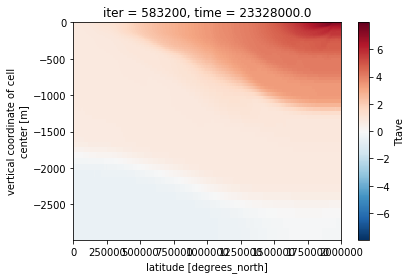

In [99]:
dTtave.Ttave[8].mean('XC').plot()

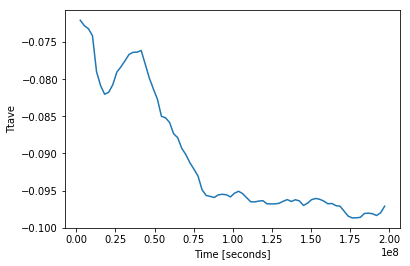

In [43]:
dTtave.Ttave.sel(Z=slice(-2000,None)).mean(['Z','YC','XC']).plot()

In [31]:
dsnap = open_mdsdataset(op.join(ddir,'zerores_01km_phys'), grid_dir=op.join(ddir,'01km_grid'),
                       iters=range(ts,te,32400), prefix=['MOMsnap'], delta_t=dt
                       )
dsnap

/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = X
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 2000, YG: 2000, Z: 76, Zl: 76, Zp1: 77, Zu: 76, time: 24)
Coordinates:
  * XC       (XC) >f4 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 6500.0 7500.0 ...
  * YC       (YC) >f4 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 6500.0 7500.0 ...
  * XG       (XG) >f4 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 6000.0 7000.0 ...
  * YG       (YG) >f4 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 6000.0 7000.0 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * Zp1      (Zp1) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * Zu       (Zu) >f4 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 -16.1 ...
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
    rA       (YC, XC) >f4 dask.array<shape=(2000, 1000), chunksize=(2000, 1000)>
    dxG      (YG, XC) >f4 dask.array<shape=(2000, 1000), chunksize=(2000, 1000)>
    dyG      (YC, XG) >f4 dask.array<shape=(2000, 1000), chunksize=(2000, 100

In [32]:
dsmon = open_mdsdataset(op.join(ddir,'zerores_01km_phys'), grid_dir=op.join(ddir,'01km_grid'),
                       iters=range(ts+64800,te+64800,64800), 
                       prefix=['uVeltave','vVeltave','wVeltave','Ttave'], delta_t=dt
                       )
dsmon

/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = X
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:   (XC: 1000, XG: 1000, YC: 2000, YG: 2000, Z: 76, Zl: 76, Zp1: 77, Zu: 76, time: 12)
Coordinates:
  * XC        (XC) >f4 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 6500.0 ...
  * YC        (YC) >f4 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 6500.0 ...
  * XG        (XG) >f4 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 6000.0 7000.0 ...
  * YG        (YG) >f4 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 6000.0 7000.0 ...
  * Z         (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * Zp1       (Zp1) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * Zu        (Zu) >f4 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * Zl        (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
    rA        (YC, XC) >f4 dask.array<shape=(2000, 1000), chunksize=(2000, 1000)>
    dxG       (YG, XC) >f4 dask.array<shape=(2000, 1000), chunksize=(2000, 1000)>
    dyG       (YC, XG) >f4 dask.array<shape=(2000, 1000), chunksize=(2000, 1000)>
    

In [33]:
dsday = open_mdsdataset(op.join(ddir,'zerores_01km_phys'), grid_dir=op.join(ddir,'01km_grid'),
                       iters=range(ts+2160,te+2160,2160), prefix=['MOMtave','KPPboundary'], delta_t=dt
                       )
dsday

/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = X
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 2000, YG: 2000, Z: 76, Zl: 76, Zp1: 77, Zu: 76, time: 360)
Coordinates:
  * XC       (XC) >f4 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 6500.0 7500.0 ...
  * YC       (YC) >f4 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 6500.0 7500.0 ...
  * XG       (XG) >f4 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 6000.0 7000.0 ...
  * YG       (YG) >f4 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 6000.0 7000.0 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * Zp1      (Zp1) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * Zu       (Zu) >f4 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 -16.1 ...
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
    rA       (YC, XC) >f4 dask.array<shape=(2000, 1000), chunksize=(2000, 1000)>
    dxG      (YG, XC) >f4 dask.array<shape=(2000, 1000), chunksize=(2000, 1000)>
    dyG      (YC, XG) >f4 dask.array<shape=(2000, 1000), chunksize=(2000, 10

In [34]:
dsday.coords['seas'] = ('time',np.tile(np.repeat(range(4),90),dy))
phisea = dsday.PHIHYD.groupby('seas').mean(['time','XC'])
dsmon.coords['seas'] = ('time',np.tile(np.repeat(range(4),3),dy))
dmsea = dsmon.groupby('seas').mean(['time','XC','XG'])
dmsea

<xarray.Dataset>
Dimensions:   (YC: 2000, YG: 2000, Z: 76, Zl: 76, Zp1: 77, Zu: 76, seas: 4)
Coordinates:
  * YC        (YC) >f4 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 6500.0 ...
  * YG        (YG) >f4 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 6000.0 7000.0 ...
  * Z         (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * Zp1       (Zp1) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * Zu        (Zu) >f4 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * Zl        (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
    drC       (Zp1) >f4 0.5 1.07 1.22 1.395 1.595 1.815 2.065 2.35 2.67 ...
    drF       (Z) >f4 1.0 1.14 1.3 1.49 1.7 1.93 2.2 2.5 2.84 3.21 3.63 4.1 ...
    PHrefC    (Z) >f4 4.905 15.4017 27.3699 41.05485 56.7018 74.50695 ...
    PHrefF    (Zp1) >f4 0.0 9.81 20.9934 33.7464 48.3633 65.0403 83.9736 ...
  * seas      (seas) int64 0 1 2 3
Data variables:
    vVeltave  (seas, Z, YG) float32 dask.array<shape=(4, 76, 2000), 

In [10]:
dsnap.coords['seas'] = ('time',np.tile(np.repeat(range(4),6),dy))
dsnap.coords['day'] = ('time',np.tile(range(24),dy))
grid = Grid(dsnap, periodic=['X'])

In [9]:
with ProgressBar():
    up = (dsnap.UVEL.groupby('seas') - dmsea.uVeltave).load()
    vp = (dsnap.VVEL.groupby('seas') - dmsea.vVeltave).load()
    wp = (dsnap.WVEL.groupby('seas') - dmsea.wVeltave).load()
up

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100

<xarray.DataArray (time: 24, Z: 76, YC: 2000, XG: 1000)>
array([[[[ 0.      , ...,  0.      ],
         ...,
         [ 0.040057, ...,  0.025762]],

        ...,

        [[ 0.      , ...,  0.      ],
         ...,
         [-0.031971, ..., -0.021224]]],


       ...,


       [[[ 0.      , ...,  0.      ],
         ...,
         [-0.060036, ..., -0.064074]],

        ...,

        [[ 0.      , ...,  0.      ],
         ...,
         [ 0.019301, ...,  0.023047]]]], dtype=float32)
Coordinates:
  * YC       (YC) >f4 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 6500.0 7500.0 ...
  * XG       (XG) >f4 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 6000.0 7000.0 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
    dyG      (YC, XG) >f4 1000.0 1000.0 1000.0 1000.0 1000.0 1000.0 1000.0 ...
    dxC      (YC, XG) >f4 1000.0 1000.0 1000.0 1000.0 1000.0 1000.0 1000.0 ...
    rAw      (YC, XG) >f4 1000000.0 1000000.0 1000000.0 1000000.0 1000000.0 ...
    drF      (Z) >f4 1.0 1.14

In [10]:
phip = dsnap.PHIHYD.groupby('seas') - phisea
bp = grid.diff(phip,'Z',boundary='fill')/grid.diff(phip.Z,'Z',boundary='fill')
with ProgressBar():
    wpbp = (wp*bp).compute()
wpbp

[########################################] | 100% Completed | 34min 11.2s


<xarray.DataArray (time: 24, Zl: 76, YC: 2000, XC: 1000)>
array([[[[-0.000000e+00, ..., -0.000000e+00],
         ...,
         [-8.255749e-07, ...,  9.575561e-08]],

        ...,

        [[ 0.000000e+00, ...,  0.000000e+00],
         ...,
         [-1.858685e-09, ...,  1.272583e-09]]],


       ...,


       [[[-0.000000e+00, ..., -0.000000e+00],
         ...,
         [-2.213079e-05, ..., -8.100223e-06]],

        ...,

        [[ 0.000000e+00, ...,  0.000000e+00],
         ...,
         [ 5.169849e-09, ...,  1.501838e-09]]]], dtype=float32)
Coordinates:
  * XC       (XC) >f4 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 6500.0 7500.0 ...
  * YC       (YC) >f4 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 6500.0 7500.0 ...
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
    rA       (YC, XC) >f4 1000000.0 1000000.0 1000000.0 1000000.0 1000000.0 ...
    Depth    (YC, XC) >f4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    iter     (time) int64 3888000 3920

In [11]:
wpbp.coords['day'] = ('time',np.tile(range(24),dy))
with ProgressBar():
    wpbpd = wpbp.sel(YC=slice(6e5,14e5)).groupby('day').mean(['time','YC','XC']).compute()
    wpbp_seas = wpbp.groupby('seas').mean(['time','XC']).compute()

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


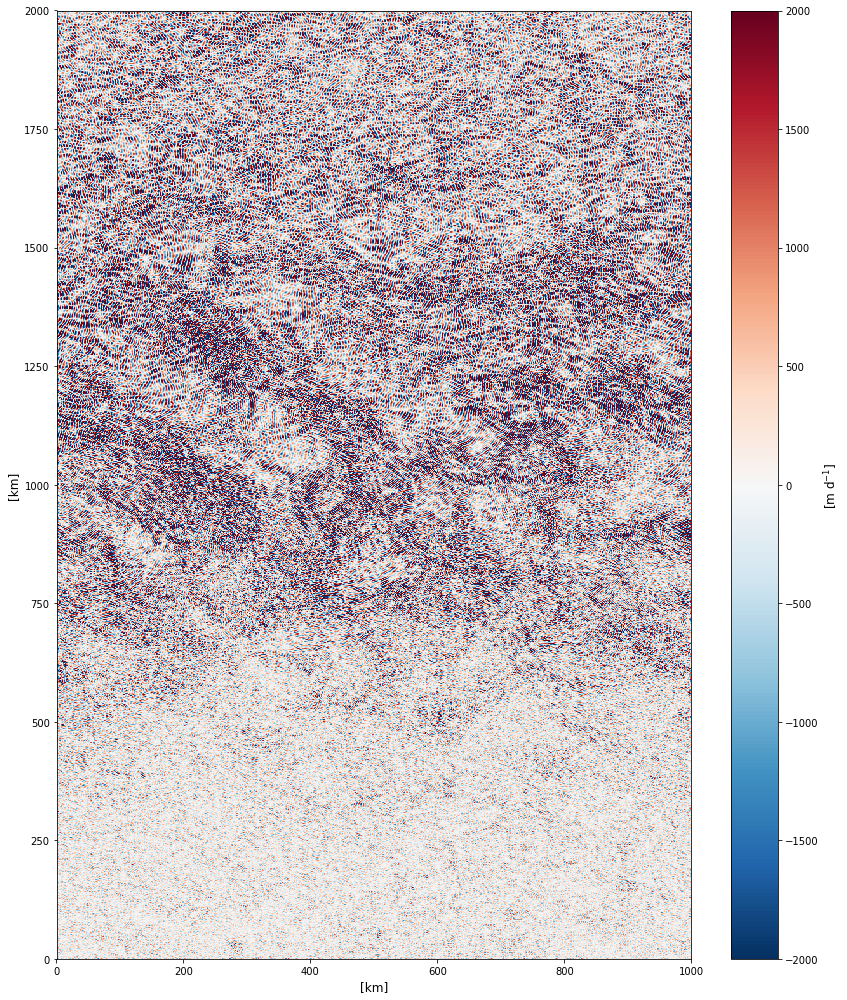

In [26]:
fig, ax = plt.subplots(figsize=(12,14))
fig.set_tight_layout(True)
im = ax.pcolormesh(dsnap.XC*1e-3, dsnap.YC*1e-3,
                  dsnap.WVEL[0,33]*86400, 
                  vmin=-2e3, vmax=2e3, cmap='RdBu_r', rasterized=True)
ax.set_xlabel(r"[km]", fontsize=12)
ax.set_ylabel(r"[km]", fontsize=12)
cbar = fig.colorbar(im)
cbar.set_label(r"[m d$^{-1}$]", fontsize=12)

In [27]:
for i in range(24):
    fig, ax = plt.subplots(figsize=(12,14))
    fig.set_tight_layout(True)
    im = ax.pcolormesh(dsnap.XC*1e-3, dsnap.YC*1e-3,
                      dsnap.WVEL[i,33]*86400, 
                      vmin=-2e3, vmax=2e3, cmap='RdBu_r', rasterized=True)
    ax.set_xlabel(r"[km]", fontsize=12)
    ax.set_ylabel(r"[km]", fontsize=12)
    cbar = fig.colorbar(im)
    cbar.set_label(r"[m d$^{-1}$]", fontsize=12)
    plt.savefig(op.join(ddir,'Figures/wsnap_z312m_01km_%02d.png' % i))
    plt.close()

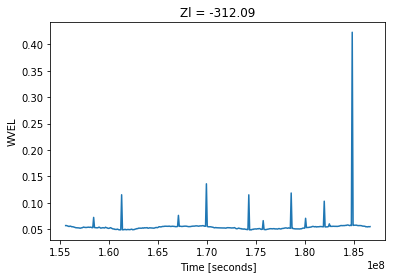

In [36]:
w1D = dsday.WVEL
np.sqrt((w1D[:,33]**2).mean(['YC','XC'])*86400).plot()

In [ ]:
for i in range(360):
    fig, ax = plt.subplots(figsize=(12,14))
    fig.set_tight_layout(True)
    im = ax.pcolormesh(dsday.XC*1e-3, dsday.YC*1e-3,
                      w1D[i,33]*86400, 
                      vmin=-1e2, vmax=1e2, cmap='RdBu_r', rasterized=True)
    ax.set_xlabel(r"[km]", fontsize=12)
    ax.set_ylabel(r"[km]", fontsize=12)
    cbar = fig.colorbar(im)
    cbar.set_label(r"[m d$^{-1}$]", fontsize=12)
    plt.savefig(op.join(ddir,'Figures/w_z312m_01km_%03d.png' % i))
    plt.close()

In [127]:
dsnap.coords['day'] = ('time',np.tile(range(24),dy))
wp.coords['day'] = ('time',np.tile(range(24),dy))
with ProgressBar():
#     w2 = ((dsnap.WVEL.sel(YC=slice(6e5,14e5))*86400)**2).groupby('day').mean(['time','YC','XC']).compute()
    w2 = ((wp.sel(YC=slice(6e5,14e5))*86400)**2).groupby('day').mean(['time','YC','XC']).compute()
w2sqrt = np.sqrt(w2)
w2sqrt

<xarray.DataArray (day: 24, Zl: 76)>
array([[   1.213667,    3.305882,    8.338753, ..., 1023.412346,  720.677537,
         393.105996],
       [   1.159044,    3.202543,    8.064716, ...,  983.780487,  692.916256,
         378.778549],
       [   1.161704,    3.198348,    8.056891, ...,  977.488689,  688.398741,
         375.954902],
       ...,
       [   1.206403,    3.327371,    8.375834, ..., 1042.117896,  733.15821 ,
         398.939613],
       [   1.327254,    3.553969,    8.996886, ..., 1102.005544,  775.182748,
         421.874992],
       [   1.239257,    3.441952,    8.663986, ..., 1077.709142,  758.154791,
         412.98748 ]])
Coordinates:
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * day      (day) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

In [10]:
u = dsnap.UVEL
v = dsnap.VVEL
w = dsnap.WVEL
phi = dsnap.PHIHYD
b = (grid.diff(phi,'Z',boundary='fill')/grid.diff(phi.Z,'Z',boundary='fill'))
uk = xrft.dft(u, dim=['XG'], shift=False)
vk = xrft.dft(v, dim=['XC'], shift=False)
wk = xrft.dft(w, dim=['XC'], shift=False)
bk = xrft.dft(b, dim=['XC'], shift=False)
with ProgressBar():
    ux = xr.DataArray(fft.ifft((2j*np.pi*uk*uk.freq_XG).data, axis=-1).real, 
                      dims=u.dims, coords=u.coords).compute()
    vx = xr.DataArray(fft.ifft((2j*np.pi*vk*vk.freq_XC).data, axis=-1).real, 
                      dims=v.dims, coords=v.coords).compute()
    wx = xr.DataArray(fft.ifft((2j*np.pi*wk*wk.freq_XC).data, axis=-1).real, 
                      dims=w.dims, coords=w.coords).compute()
    bx = xr.DataArray(fft.ifft((2j*np.pi*bk*bk.freq_XC).data, axis=-1).real, 
                      dims=b.dims, coords=b.coords).compute()
uy = grid.diff(u, 'Y', boundary='fill')/grid.diff(u.YC, 'Y', boundary='fill')
vy = grid.diff(v, 'Y', boundary='fill')/grid.diff(v.YG, 'Y', boundary='fill')
wy = grid.diff(w, 'Y', boundary='fill')/grid.diff(w.YC, 'Y', boundary='fill')
by = grid.diff(b, 'Y', boundary='fill')/grid.diff(b.YC, 'Y', boundary='fill')
bz = grid.diff(b, 'Z', boundary='fill')/grid.diff(b.Zl, 'Z', boundary='fill')

[                                        ] | 0% Completed |  0.1s

/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


[########################################] | 100% Completed |  2min  9.6s
[########################################] | 100% Completed |  2min  2.9s
[########################################] | 100% Completed |  1min 55.4s
[########################################] | 100% Completed |  2min  6.3s


In [13]:
zeta = grid.interp(vx,'X')-uy
zeta

<xarray.DataArray (time: 24, Z: 76, YG: 2000, XG: 1000)>
dask.array<shape=(24, 76, 2000, 1000), dtype=float64, chunksize=(1, 76, 1, 1000)>
Coordinates:
  * time     (time) float64 1.555e+08 1.568e+08 1.581e+08 1.594e+08 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * YG       (YG) >f4 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 6000.0 7000.0 ...
  * XG       (XG) >f4 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 6000.0 7000.0 ...

In [18]:
qs1 = (grid.interp(ux,'X')*grid.interp(bx,'Z',boundary='fill') 
      + grid.interp(vx,'Y',boundary='fill')*grid.interp(grid.interp(by,'Y',boundary='fill'),'Z',boundary='fill')
      + grid.interp(wx,'Z',boundary='fill')*bz
      )
qs2 = (grid.interp(grid.interp(uy,'X'),'Y',boundary='fill')*grid.interp(bx,'Z',boundary='fill')
      + vy*grid.interp(grid.interp(by,'Y',boundary='fill'),'Z',boundary='fill')
      + grid.interp(grid.interp(wy,'Y',boundary='fill'),'Z',boundary='fill')*bz
      )
del ux,vx,wx,uy,vy,wy
print(qs1,qs2)

<xarray.DataArray (time: 24, Z: 76, YC: 2000, XC: 1000)>
dask.array<shape=(24, 76, 2000, 1000), dtype=float64, chunksize=(1, 1, 1, 1000)>
Coordinates:
  * time     (time) float64 1.555e+08 1.568e+08 1.581e+08 1.594e+08 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * YC       (YC) >f4 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 6500.0 7500.0 ...
  * XC       (XC) >f4 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 6500.0 7500.0 ... <xarray.DataArray (time: 24, Z: 76, YC: 2000, XC: 1000)>
dask.array<shape=(24, 76, 2000, 1000), dtype=float64, chunksize=(1, 1, 1, 1000)>
Coordinates:
  * time     (time) float64 1.555e+08 1.568e+08 1.581e+08 1.594e+08 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * YC       (YC) >f4 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 6500.0 7500.0 ...
  * XC       (XC) >f4 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 6500.0 7500.0 ...


In [19]:
Fs = -(qs1*grid.interp(bx,'Z',boundary='fill') 
      + qs2*grid.interp(grid.interp(by,'Y',boundary='fill'),'Z',boundary='fill')
      )
Fs.coords['day'] = ('time',np.tile(range(24),dy))
with ProgressBar():
    Fsd = np.abs(Fs).sel(YC=slice(6e5,14e5)).groupby('day').mean(['time','YC','XC']).compute()
Fsd

[########################################] | 100% Completed |  4min 22.7s


<xarray.DataArray (day: 24, Z: 76)>
array([[6.432148e-12, 1.426977e-19, 1.419512e-19, ..., 1.116687e-19,
        1.187334e-20, 4.279756e-20],
       [5.844043e-12, 1.112130e-19, 1.107860e-19, ..., 9.300500e-20,
        1.010312e-20, 3.987325e-20],
       [5.747755e-12, 1.420145e-19, 1.412620e-19, ..., 9.293800e-20,
        1.005051e-20, 3.991334e-20],
       ...,
       [7.082234e-12, 9.241712e-20, 9.191338e-20, ..., 9.599194e-20,
        8.330665e-21, 3.095188e-20],
       [7.747751e-12, 1.282566e-19, 1.275128e-19, ..., 1.123927e-19,
        9.982417e-21, 3.637177e-20],
       [6.934481e-12, 1.005188e-19, 1.000041e-19, ..., 9.849991e-20,
        8.949676e-21, 3.554428e-20]])
Coordinates:
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * day      (day) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

In [20]:
del bx,by,bz

In [21]:
dsave = Fs.to_dataset(name='Fs')
dsave['zeta'] = zeta
dsave.to_netcdf(op.join(ddir,'zeta-Fs_01kmrun.nc'))

In [11]:
zeta = xr.open_dataset(op.join(ddir,'zeta-Fs_01kmrun.nc')).zeta
zeta

<xarray.DataArray 'zeta' (time: 24, Z: 76, YG: 2000, XG: 1000)>
[3648000000 values with dtype=float64]
Coordinates:
  * time     (time) timedelta64[ns] 1800 days 1815 days 1830 days 1845 days ...
  * Z        (Z) float32 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
    day      (time) int64 ...
  * YG       (YG) float32 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 6000.0 ...
  * XG       (XG) float32 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 6000.0 ...

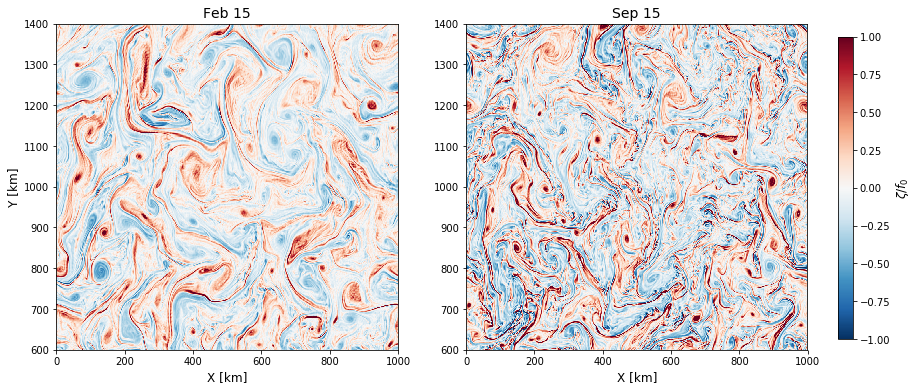

In [66]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
im = ax1.pcolormesh(zeta.XG*1e-3, zeta.YG.sel(YG=slice(6e5,14e5))*1e-3, 
                   zeta[-24:][3,0].sel(YG=slice(6e5,14e5))*f0**-1,
                   vmax=1e0, vmin=-1e0, cmap='RdBu_r', rasterized=True)

ax2.pcolormesh(zeta.XG*1e-3, zeta.YG.sel(YG=slice(6e5,14e5))*1e-3, 
              zeta[-24:][17,0].sel(YG=slice(6e5,14e5))*f0**-1,
              vmax=1e0, vmin=-1e0, cmap='RdBu_r', rasterized=True)

ax1.set_ylabel(r'Y [km]', fontsize=12)
ax1.set_xlabel(r'X [km]', fontsize=12)
# ax2.set_ylabel(r'Y [km]', fontsize=12)
ax2.set_xlabel(r'X [km]', fontsize=12)
ax1.set_title(r"Feb 15",fontsize=14)
ax2.set_title(r"Sep 15",fontsize=14)
fig.subplots_adjust(right=0.87)
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"$\zeta/f_0$", fontsize=12)
plt.savefig(op.join(ddir,'Figures/zeta_01km_snap_Feb-Sep.pdf'))

In [63]:
grid1D = Grid(dsday,periodic=['X'])
with ProgressBar():
    zeta1D100 = (grid1D.diff(dsday.VVEL[:,22],'X')/grid1D.diff(dsday.VVEL.XC,'X')
                - grid1D.diff(dsday.UVEL[:,22],'Y',boundary='fill')/grid1D.diff(dsday.UVEL.YC,'Y',boundary='fill')
                ).compute()
    zeta1D300 = (grid1D.diff(dsday.VVEL[:,33],'X')/grid1D.diff(dsday.VVEL.XC,'X')
                - grid1D.diff(dsday.UVEL[:,33],'Y',boundary='fill')/grid1D.diff(dsday.UVEL.YC,'Y',boundary='fill')
                ).compute()

[##################                      ] | 46% Completed | 16min 29.0s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[#########################               ] | 62% Completed | 29min 32.3s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 50min 37.8s
[########################################] | 100% Completed | 20min 37.8s


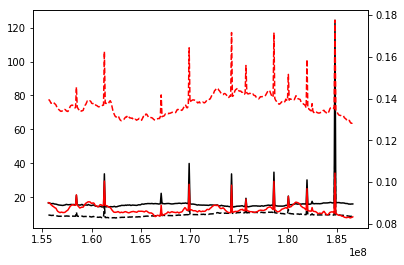

In [64]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(w1D.time, np.sqrt((w1D[:,33]**2).mean(['YC','XC']))*86400,'k')
ax2.plot(zeta1D300.time, np.sqrt(((zeta1D300/f0)**2).mean(['YG','XG'])),'r')
ax.plot(w1D.time, np.sqrt((w1D[:,22]**2).mean(['YC','XC']))*86400,'k--')
ax2.plot(zeta1D100.time, np.sqrt(((zeta1D100/f0)**2).mean(['YG','XG'])),'r--')

In [44]:
zeta.coords['seas'] = ('time',np.tile(np.repeat(range(4),6),dy))
grouped = (zeta[:,0].sel(YG=slice(6e5,14e5))*f0**-1).groupby('seas')
da = xr.DataArray(np.zeros((4,6*dy,801,1000)), dims=['seas','time','YG','XG'],
                  coords={'seas':range(4),'time':range(6*dy),
                         'YG':zeta.YG.sel(YG=slice(6e5,14e5)).data,'XG':zeta.XG.data}
                 )
i = 0
for group in grouped:
#     print(group)
    da[i] = group[1].data
    i += 1
da

<xarray.DataArray (seas: 4, time: 6, YG: 801, XG: 1000)>
array([[[[-0.3705  , ..., -0.549265],
         ...,
         [-0.124494, ..., -0.163005]],

        ...,

        [[ 0.859982, ...,  1.17445 ],
         ...,
         [ 0.014549, ...,  0.043928]]],


       ...,


       [[[-0.52673 , ..., -0.458684],
         ...,
         [ 0.339599, ...,  0.170673]],

        ...,

        [[-0.066592, ..., -0.071044],
         ...,
         [-0.16135 , ..., -0.177615]]]])
Coordinates:
  * seas     (seas) int64 0 1 2 3
  * time     (time) int64 0 1 2 3 4 5
  * YG       (YG) float32 600000.0 601000.0 602000.0 603000.0 604000.0 ...
  * XG       (XG) float32 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 6000.0 ...

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


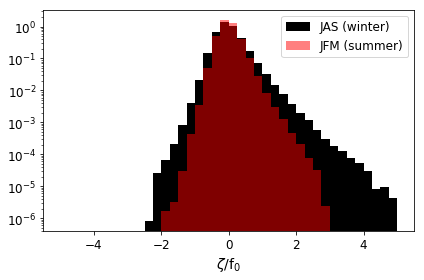

In [55]:
fig, ax = plt.subplots(figsize=(6,4))
fig.set_tight_layout(True)
ax.hist(da[2].data.ravel(), color='black', alpha=1., bins=40, range=(-5,5), 
        log=True, density=True, label='JAS (winter)')
ax.hist(da[0].data.ravel(), color='red', alpha=.5, bins=40, range=(-5,5),
        log=True, density=True, label='JFM (summer)')
ax.set_xlabel(r"$\zeta$/f$_0$", fontsize=14)
ax.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(op.join(ddir,'Figures/zeta_histogram_01km.pdf'))

In [111]:
# hbl = dsphi.KPPhbl
# hbl99 = xr.DataArray(np.percentile(hbl, 99, axis=-1), dims=['time','YC'],
#                     coords={'time':dsphi.time,'YC':dsphi.YC})
# hbl99.coords['day'] = ('time',np.tile(range(360),dy))
# hbl99.coords['seas'] = ('time',np.tile(np.repeat(range(4),90),dy))
# hbl99.coords['month'] = ('time',np.tile(np.repeat(range(12),30),dy))
# hbl99.to_dataset(name='hbl99').to_netcdf(op.join(ddir,'KPPhbl_99percentile_01km.nc'))
hbl99 = xr.open_dataset(op.join(ddir,'KPPhbl_99percentile_01km.nc')).hbl99
with ProgressBar():
    hbl99_day = hbl99.groupby('day').mean('time').compute()
    hbl99_sea = hbl99.groupby('seas').mean('time').compute()
#     hbl99_mon = hbl99.groupby('month').mean('time').compute()
hbl99_day

<xarray.DataArray (day: 360, YC: 2000)>
array([[  0.      , 617.072106, 606.241516, ...,  30.      ,  30.      ,
         30.      ],
       [  0.      , 619.199315, 595.608069, ...,  30.      ,  30.      ,
         30.      ],
       [  0.      , 604.607151, 597.115917, ...,  30.      ,  30.      ,
         30.      ],
       ...,
       [  0.      , 399.959416, 398.77134 , ...,  30.      ,  30.      ,
         30.      ],
       [  0.      , 410.441038, 405.138849, ...,  30.      ,  30.      ,
         30.      ],
       [  0.      , 398.521544, 240.244216, ...,  30.      ,  30.      ,
         30.      ]])
Coordinates:
  * YC       (YC) >f4 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 6500.0 7500.0 ...
  * day      (day) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

In [ ]:
hbl99_day.sel(YC=slice(nys,nyn)).mean(['YC'])

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


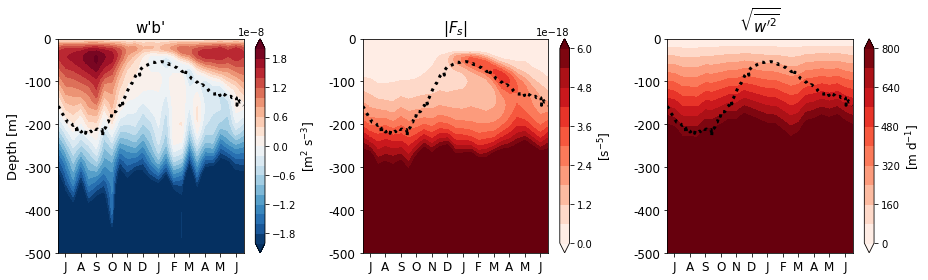

In [128]:
nys, nyn = (6e5,14e5)
month = ['J','F','M','A','M','J','J','A','S','O','N','D']

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(13,4))
fig.set_tight_layout(True)
im1 = ax1.contourf(np.linspace(0,345,24), wpbpd.Zl, wpbpd.T.roll(day=-12), 
                  levels=1e-8*np.linspace(-2,2.,21), 
                   extend='both', cmap='RdBu_r')
ax1.contourf(np.linspace(14,359,24), wpbpd.Zl, wpbpd.T.roll(day=-13), 
            levels=1e-8*np.linspace(-2,2.,21), 
            extend='both', cmap='RdBu_r')
im2 = ax2.contourf(np.linspace(0,345,24), Fsd.Z, Fsd.T.roll(day=-12), 
                  levels=1e-18*np.linspace(0,6,11), 
                  cmap='Reds', extend='both')
ax2.contourf(np.linspace(14,359,24), Fsd.Z, Fsd.T.roll(day=-13), 
            levels=1e-18*np.linspace(0,6,11), 
            cmap='Reds', extend='both')
im3 = ax3.contourf(np.linspace(0,345,24), w2sqrt.Zl, w2sqrt.T.roll(day=-12), 
                  levels=1e2*np.linspace(0,8,11), 
                  cmap='Reds', extend='both')
ax3.contourf(np.linspace(14,359,24), w2sqrt.Zl, w2sqrt.T.roll(day=-13), 
            levels=1e2*np.linspace(0,8,11), 
            cmap='Reds', extend='both')
ax1.plot(range(360), -hbl99_day.sel(YC=slice(nys,nyn)).mean(['YC']).roll(day=-180), 
        ls=':', lw=3, color='k')
ax2.plot(range(360), -hbl99_day.sel(YC=slice(nys,nyn)).mean(['YC']).roll(day=-180), 
        ls=':', lw=3, color='k')
ax3.plot(range(360), -hbl99_day.sel(YC=slice(nys,nyn)).mean(['YC']).roll(day=-180), 
        ls=':', lw=3, color='k')
ax1.set_ylim([-5e2,0])
ax1.set_xlim([0.,359.])
ax2.set_ylim([-5e2,0])
ax2.set_xlim([0.,359.])
ax3.set_ylim([-5e2,0])
ax3.set_xlim([0.,359.])
ax1.set_title(r"w'b'", fontsize=15)
ax2.set_title(r"|$F_s$|", fontsize=15)
ax3.set_title(r"$\sqrt{\overline{w'^2}}$", fontsize=15)
ax1.set_xticks(np.linspace(14,344,12))
ax1.set_xticklabels(np.roll(np.array(month),-6), fontsize=12)
ax2.set_xticks(np.linspace(14,344,12))
ax2.set_xticklabels(np.roll(np.array(month),-6), fontsize=12)
ax3.set_xticks(np.linspace(14,344,12))
ax3.set_xticklabels(np.roll(np.array(month),-6), fontsize=12)
ax1.set_yticklabels(np.array([-500,-400,-300,-200,-100,0]), fontsize=12)
ax2.set_yticklabels(np.array([-500,-400,-300,-200,-100,0]), fontsize=12)
ax3.set_yticklabels(np.array([-500,-400,-300,-200,-100,0]), fontsize=12)
ax1.set_ylabel(r"Depth [m]", fontsize=13)
# ax2.set_xlabel(r"Month", fontsize=13)
# fig.subplots_adjust(right=0.88)
# cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
# cbar = fig.colorbar(im, cax=cbar_ax)
cbar1 = fig.colorbar(im1, ax=ax1)
cbar2 = fig.colorbar(im2, ax=ax2)
cbar3 = fig.colorbar(im3, ax=ax3)
cbar1.set_label(r"[m$^{2}$ s$^{-3}$]", fontsize=12)
cbar2.set_label(r"[s$^{-5}$]", fontsize=12)
cbar3.set_label(r"[m d$^{-1}$]", fontsize=12)
plt.savefig(op.join(ddir,'Figures/wb-Fs-w2_01km.pdf'))

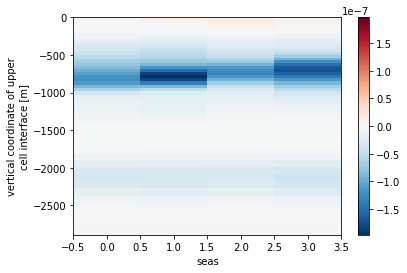

In [124]:
wpbp_seas.sel(YC=slice(6e5,14e5)).T.mean('YC').plot()

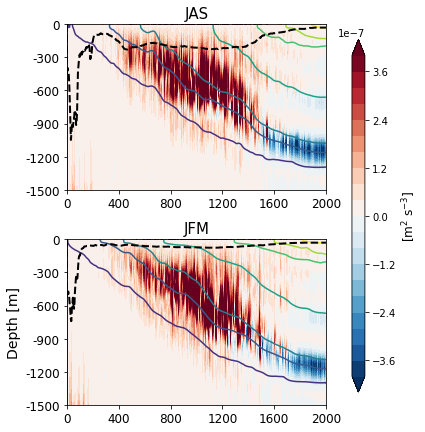

In [122]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,7))
im = ax1.contourf(wpbp_seas.YC*1e-3, wpbp_seas.Zl, wpbp_seas[2],
                 levels=np.linspace(-4e-7,4e-7,21), cmap='RdBu_r', extend='both')
ax1.contour(dvclm.YC*1e-3, dvclm.Z, dvclm.Ttave[2], 
           levels=np.linspace(-1,8,10))
# ax1.plot(MLD_seas.YC*1e-3, -MLD_seas[2], 'k', lw=2)
ax1.plot(hbl99_sea.YC*1e-3, -hbl99_sea[2], 'k--', lw=2)

ax2.contourf(wpbp_seas.YC*1e-3, wpbp_seas.Zl, wpbp_seas[0],
            levels=np.linspace(-4e-7,4e-7,21), cmap='RdBu_r', extend='both')
ax2.contour(dvclm.YC*1e-3, dvclm.Z, dvclm.Ttave[0], 
           levels=np.linspace(-1,8,10))
# ax2.plot(MLD_seas.YC*1e-3, -MLD_seas[0], 'k', lw=2)
ax2.plot(hbl99_sea.YC*1e-3, -hbl99_sea[0], 'k--', lw=2)
ax1.set_ylim([-1500,0])
ax2.set_ylim([-1500,0])
ax1.set_xticks(np.array([0,400,800,1200,1600,2000]))
ax2.set_xticks(np.array([0,400,800,1200,1600,2000]))
ax1.set_xticklabels(np.array([0,400,800,1200,1600,2000]), fontsize=12)
ax2.set_xticklabels(np.array([0,400,800,1200,1600,2000]), fontsize=12)
ax1.set_yticks(np.array([-1500,-1200,-900,-600,-300,0]))
ax2.set_yticks(np.array([-1500,-1200,-900,-600,-300,0]))
ax1.set_yticklabels(np.array([-1500,-1200,-900,-600,-300,0]), fontsize=12)
ax2.set_yticklabels(np.array([-1500,-1200,-900,-600,-300,0]), fontsize=12)
ax2.set_ylabel(r'Depth [m]', fontsize=14)
# ax1.set_xlabel(r'Y [km]', fontsize=14)
# ax2.set_xlabel(r'Y [km]', fontsize=14)
ax1.set_title(r"JAS",fontsize=15)
ax2.set_title(r"JFM",fontsize=15)
fig.subplots_adjust(left=0.2, right=0.8, hspace=0.3)
cbar_ax = fig.add_axes([0.86, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"[m$^2$ s$^{-3}$]", fontsize=12)
plt.savefig(op.join(ddir,'Figures/wb_01km_seasclim_JFM-JAS_2rows.pdf'))

In [19]:
with ProgressBar():
    uk2 = xrft.power_spectrum(grid.interp(up,'X').sel(YC=slice(6e5,1.4e6)).chunk(chunks={'XC':1000}),
                             dim=['XC'], detrend='constant').compute()
    vk2 = xrft.power_spectrum(grid.interp(vp,'Y',boundary='fill').sel(YC=slice(6e5,1.4e6)
                                                                     ).chunk(chunks={'XC':1000}),
                             dim=['XC'], detrend='constant').compute()

ekek = uk2 + vk2
ekek

[###                                     ] | 9% Completed |  0.1s

/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


[########################################] | 100% Completed |  2min 48.5s
[###                                     ] | 9% Completed |  0.1s

/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


[########################################] | 100% Completed |  2min 53.7s


<xarray.DataArray (time: 24, Z: 76, YC: 800, freq_XC: 1000)>
array([[[[2.014777e-05, ..., 1.140593e-05],
         ...,
         [2.809100e-06, ..., 1.791518e-05]],

        ...,

        [[9.828312e-06, ..., 1.590559e-06],
         ...,
         [3.302766e-05, ..., 1.920504e-05]]],


       ...,


       [[[5.429317e-07, ..., 9.051006e-06],
         ...,
         [3.035202e-06, ..., 2.796888e-06]],

        ...,

        [[5.592168e-07, ..., 4.602348e-07],
         ...,
         [2.301467e-06, ..., 5.687445e-06]]]])
Coordinates:
  * time             (time) float64 1.555e+08 1.568e+08 1.581e+08 1.594e+08 ...
  * Z                (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 ...
  * YC               (YC) >f4 600500.0 601500.0 602500.0 603500.0 604500.0 ...
  * freq_XC          (freq_XC) float64 -0.0005 -0.000499 -0.000498 -0.000497 ...
    freq_XC_spacing  float64 1e-06

In [20]:
seas = ('time',np.tile(np.repeat(range(4),6),dy))
ekek.coords['seas'] = seas
ekek.to_dataset(name='eke').to_netcdf(op.join(ddir,'EKEk_01kmrun.nc'))

In [22]:
pdir = '/swot/SUM05/takaya/MITgcm/channel/runs/'
ekek05 = xr.open_dataset(op.join(pdir, 'EKEk_05kmrun.nc')).eke
ekek20 = xr.open_dataset(op.join(pdir, 'EKEk_20kmrun.nc')).eke
# ds2 = xr.open_dataset(op.join(avisodir, 'JASON2_45-55S_100-150E_JFMekespectra.nc'))
# ds3 = xr.open_dataset(op.join(avisodir, 'JASON2_45-55S_100-150E_JASekespectra.nc'))
ekek01_seas = ekek.groupby('seas').mean('time')
ekek05_seas = ekek05.groupby('seas').mean('time')
ekek20_seas = ekek20.groupby('seas').mean('time')
ds1 = xr.open_dataset('/home/takaya/AVISO/AVISO_EKEk_56-61S.nc')
eke_AVISO = ds1.eke.mean('latitude')
k_AVISO = ds1.kx.mean('lat')
N = eke_AVISO.shape
# jsn2JFM = ds2.JFM
# jsn2JAS = ds3.JAS
# kjsn = ds2.kr

In [23]:
seasAV = np.array([0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,3])
eke_AVISO_yrs = eke_AVISO[:598]
print(eke_AVISO_yrs)
eke_AVISO_yrs.coords['DinY'] = ('days',np.tile(seasAV,23))
eke_AVISO_seas = eke_AVISO_yrs.groupby('DinY').mean('days')
eke_AVISO_seas

<xarray.DataArray 'eke' (days: 598, freq_longitude: 1440)>
array([[2.828993e-10, 3.929395e-10, 4.323431e-10, ..., 3.682711e-10,
        4.323431e-10, 3.929395e-10],
       [3.830729e-10, 3.834541e-10, 4.026887e-10, ..., 4.707198e-10,
        4.026887e-10, 3.834541e-10],
       [3.012153e-10, 4.933155e-10, 5.644254e-10, ..., 4.873114e-10,
        5.644254e-10, 4.933155e-10],
       ...,
       [1.438368e-08, 1.441389e-08, 1.470313e-08, ..., 1.737978e-08,
        1.470313e-08, 1.441389e-08],
       [2.569444e-09, 5.152211e-09, 3.922301e-09, ..., 3.279705e-09,
        3.922301e-09, 5.152211e-09],
       [2.535069e-09, 3.051711e-09, 2.951270e-09, ..., 2.936089e-09,
        2.951270e-09, 3.051711e-09]])
Coordinates:
  * days                    (days) int64 0 14 28 42 56 70 84 98 112 126 140 ...
  * freq_longitude          (freq_longitude) float64 -2.0 -1.997 -1.994 ...
    freq_longitude_spacing  float64 ...


<xarray.DataArray 'eke' (DinY: 4, freq_longitude: 1440)>
array([[4.351772e-10, 4.315060e-10, 4.226446e-10, ..., 4.242275e-10,
        4.226446e-10, 4.315060e-10],
       [4.187558e-10, 4.180976e-10, 4.224793e-10, ..., 4.270869e-10,
        4.224793e-10, 4.180976e-10],
       [3.574422e-09, 3.623521e-09, 3.644584e-09, ..., 3.598471e-09,
        3.644584e-09, 3.623521e-09],
       [4.713173e-09, 4.724282e-09, 4.596361e-09, ..., 4.806354e-09,
        4.596361e-09, 4.724282e-09]])
Coordinates:
  * freq_longitude          (freq_longitude) float64 -2.0 -1.997 -1.994 ...
    freq_longitude_spacing  float64 ...
  * DinY                    (DinY) int64 0 1 2 3

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


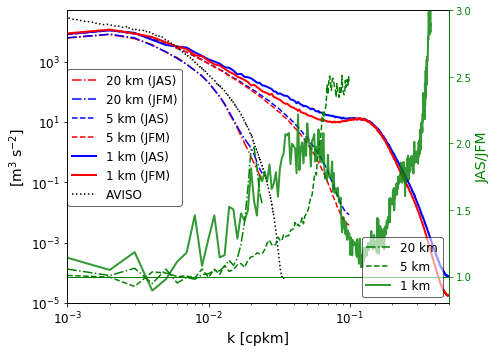

In [125]:
seasons = ['JFM','AMJ','JAS','OND']
colors = ['r','brown','b','g']
g = 9.8
trans = 1.

fig, ax = plt.subplots(figsize=(7,5))
fig.set_tight_layout(True)
ax2 = ax.twinx()
# ax.plot(ekek20.freq_XC[26:]*1e3, ekek20[:,0,:,26:].sel(YC=slice(6e5,14e5)).mean(['time','YC']),
#        'k--', lw=1.5, label='20 km')
ax.plot(ekek20.freq_XC[26:]*1e3, ekek20_seas[0,0,:,26:].sel(YC=slice(6e5,14e5)).mean(['YC']),
       'r-.', lw=1.5, alpha=trans, label='20 km (JAS)')
ax.plot(ekek20.freq_XC[26:]*1e3, ekek20_seas[2,0,:,26:].sel(YC=slice(6e5,14e5)).mean(['YC']),
       'b-.', lw=1.5, alpha=trans, label='20 km (JFM)')

# ax.plot(ekek.freq_XC[100:]*1e3, ekek[:,0,:,100:].sel(YC=slice(10e5,12e5)).mean(['time','YC'])*ekek.freq_XC[100:]**-1,
#        'k--', lw=2, label='5 km')
# ax.plot(ekek.freq_XC[100:]*1e3, ekek_seas[3,0,:,100:].sel(YC=slice(6e5,14e5)).mean(['YC']),
#        'g', lw=1, label='5 km (OND)')
# ax.plot(ekek.freq_XC[100:]*1e3, ekek_seas[1,0,:,100:].sel(YC=slice(6e5,14e5)).mean(['YC']),
#        color='brown', lw=1, label='5 km (AMJ)')
ax.plot(ekek05.freq_XC[101:]*1e3, ekek05_seas[2,0,:,101:].sel(YC=slice(6e5,14e5)).mean(['YC']),
       'b--', lw=1.5, alpha=trans, label='5 km (JAS)')
ax.plot(ekek05.freq_XC[101:]*1e3, ekek05_seas[0,0,:,101:].sel(YC=slice(6e5,14e5)).mean(['YC']),
       'r--', lw=1.5, alpha=trans, label='5 km (JFM)')

ax.plot(ekek.freq_XC[501:]*1e3, ekek01_seas[2,0,:,501:].sel(YC=slice(6e5,14e5)).mean(['YC']),
       'b', lw=2, alpha=trans, label='1 km (JAS)')
ax.plot(ekek.freq_XC[501:]*1e3, ekek01_seas[0,0,:,501:].sel(YC=slice(6e5,14e5)).mean(['YC']),
       'r', lw=2, alpha=trans, label='1 km (JFM)')
# ax.plot(ekek.freq_XC[100:]*1e3, ekek[:,39,:,100:].sel(YC=slice(6e5,14e5)).mean(['time','YC']),
#        color='k', lw=2, label='5 km (%3d m)' % -ekek.Z[39])
# ax.plot(ekek.freq_XC[100:]*1e3, ekek_seas[2,20,:,100:].sel(YC=slice(10e5,12e5)).mean(['YC'])*ekek.freq_XC[100:]**-1,
#        color='b', alpha=0.6, lw=2, label='5 km (540m)')
# ax.plot(ekek.freq_XC[100:]*1e3, ekek_seas[0,20,:,100:].sel(YC=slice(10e5,12e5)).mean(['YC'])*ekek.freq_XC[100:]**-1,
#        color='r', alpha=0.6, lw=2, label='5 km (540m)')
# ax.plot(ekek.freq_XC[100:]*1e3, ekek[:,26,:,100:].sel(YC=slice(10e5,12e5)).mean(['time','YC'])*ekek.freq_XC[100:]**-1,
#        color='grey', lw=2, label='5 km (1040m)')

# ax.plot(kjsn[121:]*1e3, jsn2JFM.mean('nDATA')[121:]*kjsn*(g/np.abs(gsw.f(-50.)))**2, 
#         'r-.', lw=2, label=r"JASON2 (JFM)")
# ax.plot(kjsn[121:]*1e3, jsn2JAS.mean('nDATA')[121:]*kjsn*(g/np.abs(gsw.f(-50.)))**2, 
#         'b-.', lw=2, label=r"JASON2 (JFM)")
# ax.plot(k_AVISO[20:]*1e3, eke_AVISO[:,int(.5*N[1])+20:].mean('days').data*k_AVISO[20:]**-1,
#        'k:', lw=2, label='AVISO')
ax.plot(k_AVISO[20:]*1e3, eke_AVISO_seas.mean('DinY')[int(.5*N[1])+20:].data*k_AVISO[20:]**-1,
       'k:', alpha=trans, label='AVISO')
# ax.plot(k_AVISO[20:]*1e3, eke_AVISO_seas[0,int(.5*N[1])+20:].data*k_AVISO[20:]**-1,
#        'r:', lw=1., alpha=trans, label='AVISO (JFM)')

ax2.plot(ekek20.freq_XC[26:]*1e3, (ekek20_seas[2,0,:,26:]/ekek20_seas[0,0,:,26:]).sel(YC=slice(6e5,14e5)).mean(['YC']),
        'g-.', lw=1.5, label='20 km', alpha=1.)
ax2.plot(ekek05.freq_XC[101:]*1e3, (ekek05_seas[2,0,:,101:]
                                   /ekek05_seas[0,0,:,101:]).sel(YC=slice(6e5,14e5)).mean(['YC']),
        'g--', lw=1.5, label='5 km', alpha=1.)
im, = ax2.plot(ekek.freq_XC[501:]*1e3, (ekek01_seas[2,0,:,501:]
                                         /ekek01_seas[0,0,:,501:]).sel(YC=slice(6e5,14e5)).mean(['YC']),
              'g', lw=2, label='1 km', alpha=.8)
# ax2.plot(k_AVISO[20:-50][::5]*1e3, (eke_AVISO_seas[2,int(.5*N[1])+20:-50]/eke_AVISO_seas[0,int(.5*N[1])+20:-50])[::5],
#         'g:', lw=1., label='AVISO', alpha=1.)
# ax2.plot(kjsn[121:]*1e3, (jsn2JAS.mean('nDATA') / jsn2JFM.mean('nDATA'))[121:], 
#          'g-.', lw=1., label='JASON2', alpha=1.)
ax2.plot(np.linspace(1e-3,5e-1,10), np.ones(10), 'g', lw=1)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-3,5e-1])
ax.set_xticks([1e-3,1e-2,1e-1])
ax.set_xticklabels([1e-3,1e-2,1e-1], fontsize=12)
ax.set_ylim([1e-5,5e4])
ax.set_yticks([1e-5,1e-3,1e-1,1e1,1e3])
ax.set_yticklabels([1e-5,1e-3,1e-1,1e1,1e3], fontsize=12)
ax.get_xaxis().set_major_formatter(tick.LogFormatterSciNotation())
ax.get_yaxis().set_major_formatter(tick.LogFormatterSciNotation())
ax2.set_xscale('log')
ax2.set_ylim([0.8,3])
ax2.set_yticks([1.,1.5,2.,2.5,3.])
ax2.set_yticklabels([1.,1.5,2.,2.5,3.], fontsize=12)
ax2.spines["right"].set_edgecolor(im.get_color())
ax2.yaxis.label.set_color(im.get_color())
ax2.tick_params(axis='y', colors=im.get_color())
ax.set_xlabel(r'k [cpkm]', fontsize=14)
ax.set_ylabel(r'[m$^3$ s$^{-2}$]', fontsize=14)
ax2.set_ylabel(r'JAS/JFM', fontsize=14)
# lg = ax.legend(loc='upper left', fontsize=12, framealpha=.6, frameon=1.)
lg = ax.legend(bbox_to_anchor=(0, .8), loc=2, borderaxespad=0., fontsize=12, framealpha=.6, frameon=1.)
lg2 = ax2.legend(loc='lower right', fontsize=12, framealpha=.6, frameon=1.)
frame = lg.get_frame()
frame.set_color('white')
frame.set_edgecolor('black')
frame2 = lg2.get_frame()
frame2.set_color('white')
frame2.set_edgecolor('black')
# cbar = fig.colorbar(im, ax=ax)
# cbar.set_label(r"[m$^3$ s$^{-2}$]", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig(op.join(pdir,'Figures/EKEkclim_MIT_AVISO.pdf'))

In [51]:
ekek.freq_XC[-480:-400]**-1*1e-3

<xarray.DataArray 'freq_XC' (freq_XC: 80)>
array([50.      , 47.619048, 45.454545, 43.478261, 41.666667, 40.      ,
       38.461538, 37.037037, 35.714286, 34.482759, 33.333333, 32.258065,
       31.25    , 30.30303 , 29.411765, 28.571429, 27.777778, 27.027027,
       26.315789, 25.641026, 25.      , 24.390244, 23.809524, 23.255814,
       22.727273, 22.222222, 21.73913 , 21.276596, 20.833333, 20.408163,
       20.      , 19.607843, 19.230769, 18.867925, 18.518519, 18.181818,
       17.857143, 17.54386 , 17.241379, 16.949153, 16.666667, 16.393443,
       16.129032, 15.873016, 15.625   , 15.384615, 15.151515, 14.925373,
       14.705882, 14.492754, 14.285714, 14.084507, 13.888889, 13.69863 ,
       13.513514, 13.333333, 13.157895, 12.987013, 12.820513, 12.658228,
       12.5     , 12.345679, 12.195122, 12.048193, 11.904762, 11.764706,
       11.627907, 11.494253, 11.363636, 11.235955, 11.111111, 10.989011,
       10.869565, 10.752688, 10.638298, 10.526316, 10.416667, 10.309278,
       1

In [52]:
nk50km = -480
dx = 1e3
eke50 = (ekek[:,:,:,nk50km:]*ekek.freq_XC[nk50km]).sum('freq_XC')

In [56]:
nz100 = 22
eke_zave = (eke50[:,:nz100]*dsnap.drF[:nz100]).sum('Z') * np.abs(dsnap.Zl[nz100]**-1)
eke_zave.coords['day'] = ('time',np.tile(range(24),dy))
eke_std = eke_zave.sel(YC=slice(6e5,1.4e6)).groupby('day').std(['time','YC'])
eke_mean = eke_zave.sel(YC=slice(6e5,1.4e6)).groupby('day').mean(['time','YC'])
eke_zave

<xarray.DataArray (time: 24, YC: 800)>
dask.array<shape=(24, 800), dtype=float64, chunksize=(24, 800)>
Coordinates:
  * time             (time) float64 1.555e+08 1.568e+08 1.581e+08 1.594e+08 ...
  * YC               (YC) >f4 600500.0 601500.0 602500.0 603500.0 604500.0 ...
    freq_XC_spacing  float64 1e-06
    seas             (time) int64 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 ...
    Zl               >f4 -105.22
    day              (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...

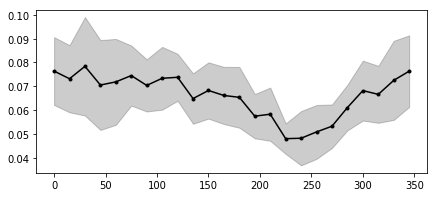

In [57]:
fig, ax = plt.subplots(figsize=(7,3))
ax.plot(range(0,360,15), eke_mean.roll(day=-12), 'k.-')
ax.fill_between(range(0,360,15), (eke_mean-eke_std).roll(day=-12), 
               (eke_mean+eke_std).roll(day=-12), color='k', alpha=0.2)

In [92]:
(155520)*50/86400

90.0

In [91]:
(129600+25920)*50/2

3888000.0